<a href="https://colab.research.google.com/github/UiinKim/UiinKim/blob/main/BiLSTM%EC%9C%BC%EB%A1%9C_%ED%95%9C%EA%B5%AD%EC%96%B4_%EC%8A%A4%ED%8C%80_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 31.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7d71c1aaf1c0>)

In [5]:
total_data=pd.read_table('steam.txt', names=['label', 'reviews'])

In [6]:
total_data.head()

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [7]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    100000 non-null  int64 
 1   reviews  100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [8]:
total_data.nunique()

label          2
reviews    99892
dtype: int64

In [9]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print(len(total_data))

99892


In [10]:
#훈련데이터와 테스트 데이터 분리
train_data, test_data=train_test_split(total_data, test_size=0.25, random_state=42)
print("훈련용 리뷰 개수 : ", len(train_data))
print("테스트용 리뷰 개수 : ", len(test_data))

훈련용 리뷰 개수 :  74919
테스트용 리뷰 개수 :  24973


<Axes: >

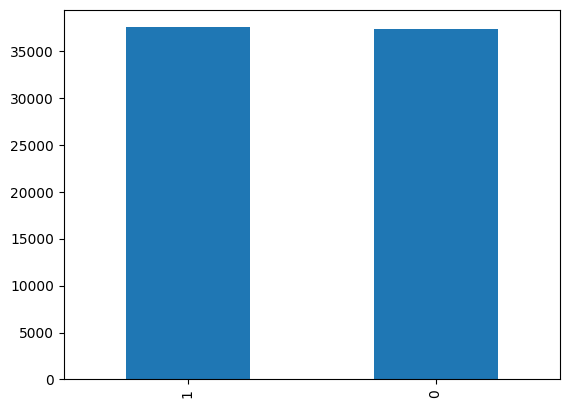

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name='counts'))

   label  counts
0      0   37376
1      1   37543


In [13]:
#데이터 정제
train_data.drop_duplicates(subset=['reviews'], inplace=True)
train_data['reviews']=train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
train_data['reviews']=train_data['reviews'].replace('', np.nan)
train_data.isnull().sum()

<ipython-input-13-159aa2b6927a>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews']=train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')


label      0
reviews    0
dtype: int64

In [14]:
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews']=test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
test_data['reviews']=test_data['reviews'].replace('',np.nan)
test_data.isnull().sum()

<ipython-input-14-f71194b913c4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews']=test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')


label      0
reviews    0
dtype: int64

In [15]:
okt=Okt()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [16]:
from tqdm import tqdm

In [17]:
X_train=[]
for sentence in tqdm(train_data['reviews']):
  tokenized_sentence=okt.morphs(sentence)
  stopwords_removed_sentence=[word for word in tokenized_sentence if not word in stopwords]
  X_train.append(stopwords_removed_sentence)
y_train=train_data['label']

100%|██████████| 74919/74919 [36:45<00:00, 33.97it/s]


In [18]:
X_test=[]
for sentence in tqdm(test_data['reviews']):
  tokenized_sentence=okt.morphs(sentence)
  stopwords_removed_sentence=[word for word in tokenized_sentence if not word in stopwords]
  X_test.append(stopwords_removed_sentence)
y_test=test_data['label']

100%|██████████| 24973/24973 [12:16<00:00, 33.90it/s]


In [19]:
#정수 인코딩
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [20]:
threshold=2
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0

for key, value in tokenizer.word_counts.items():
  total_freq+=value
  if value<threshold:
    rare_cnt+=1
    rare_freq+=value

print("유니크한 단어 개수의 비율 : ", (rare_cnt/total_cnt)*100)
print("유니크한 단어 출현빈도 비율 : ", (rare_freq/total_freq)*100)

유니크한 단어 개수의 비율 :  60.281727663258856
유니크한 단어 출현빈도 비율 :  5.590729679479656


In [21]:
vocab_size=total_cnt-rare_cnt+2
print("단어 집합의 크기 : ", vocab_size)

단어 집합의 크기 :  35783


In [22]:
tokenizer=Tokenizer(vocab_size, oov_token='oov')
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

가장 긴 토큰 :  56
토큰의 평균 길이 :  12.965442678092339


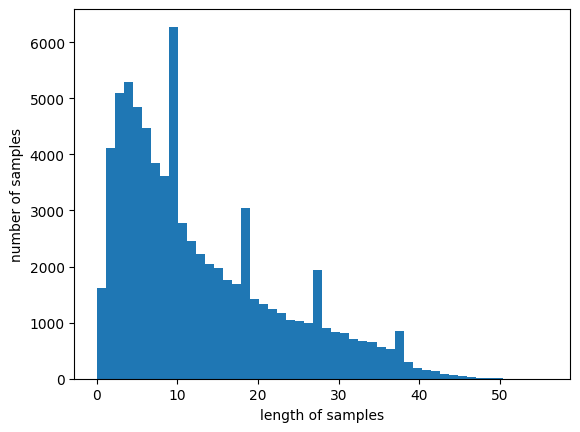

In [23]:
print("가장 긴 토큰 : ", max(len(word)for word in X_train))
print("토큰의 평균 길이 : ", sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
  count=0

  for sentence in nested_list:
    if len(sentence)<max_len:
      count+=1

  print("%s의 threshold보다 낮은 비율은 %s입니다." %(max_len, count/len(nested_list)*100))

In [25]:
max_len=60
below_threshold_len(max_len, X_train)

60의 threshold보다 낮은 비율은 100.0입니다.


In [26]:
#패딩
X_train=pad_sequences(X_train, maxlen=max_len)
X_test=pad_sequences(X_test, maxlen=max_len)

In [27]:
import re
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
embedding_dim=100
hidden_units=128

model=Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(1, activation='sigmoid'))

es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history=model.fit(X_train,y_train, callbacks=[es, mc], batch_size=256, epochs=15, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.6380 - acc: 0.6157
Epoch 1: val_acc improved from -inf to 0.73171, saving model to best_model.h5
235/235 [==============================] - 199s 812ms/step - loss: 0.6380 - acc: 0.6157 - val_loss: 0.5303 - val_acc: 0.7317
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4889 - acc: 0.7688
Epoch 2: val_acc improved from 0.73171 to 0.76168, saving model to best_model.h5
235/235 [==============================] - 176s 748ms/step - loss: 0.4889 - acc: 0.7688 - val_loss: 0.4908 - val_acc: 0.7617
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4261 - acc: 0.8094
Epoch 3: val_acc improved from 0.76168 to 0.77109, saving model to best_model.h5
235/235 [==============================] - 171s 726ms/step - loss: 0.4261 - acc: 0.8094 - val_loss: 0.4801 - val_acc: 0.7711
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3915 - acc: 0.8288
Epoch 4: val_acc impr

In [29]:
loaded_model=load_model('best_model.h5')
print("\n 모델의 테스트 정확도 : %.4f"%(loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 49s 61ms/step - loss: 0.4903 - acc: 0.7741

 모델의 테스트 정확도 : 0.7741


In [30]:
def sentiment_predict(new_sentence):
  new_sentence=re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "", new_sentence)
  new_sentence=okt.morphs(new_sentence)
  new_sentence=[word for word in new_sentence if not word in stopwords]
  encoded=tokenizer.texts_to_sequences([new_sentence])
  paded=pad_sequences(encoded, maxlen=max_len)
  score=float(loaded_model.predict(paded))

  if score>0.5:
    print("{:.2f}%의 확률로 긍정리뷰입니다.".format(score*100))
  else:
    print("{:.2f}%의 확률로 부정리뷰입니다.".format((1-score)*100))

In [31]:
sentiment_predict('ㅈ노잼이네')

1/1 [==============================] - 3s 3s/step
96.74%의 확률로 부정리뷰입니다.


In [32]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 [==============================] - 0s 46ms/step
99.70%의 확률로 긍정리뷰입니다.
